# **Tire Texture Analysis for Crack Detection Using Convolutional Neural Networks**

1. **Final Project RMT 045 – Group 01**
- Data Analyst : Rivaldi Revin
- Data Scientist : Hafiz Alfariz
- Data Scientist : I Gusti Ngurah Bagus Dwira Palguna
- Data Engineer : Fhad Saleh

2. **Latar Belakang**

Kerusakan ban kendaraan, khususnya retakan pada permukaan ban, sering kali sulit dideteksi secara dini karena perbedaannya yang halus dan membutuhkan pemeriksaan visual mendetail. Proses pemeriksaan manual tidak hanya memakan waktu, tetapi juga bergantung pada keahlian individu sehingga rentan terhadap subjektivitas dan inkonsistensi. Dengan pendekatan Computer Vision menggunakan Convolutional Neural Network (CNN), sistem dapat secara otomatis mengenali tekstur ban dan mengklasifikasikannya ke dalam kategori normal atau cracked. Pemanfaatan dataset berupa citra tekstur ban yang telah terlabel dengan baik memungkinkan model untuk belajar pola visual yang relevan, sehingga analisis kondisi ban dapat dilakukan lebih cepat, akurat, dan konsisten. Hasil dari pendekatan ini diharapkan mampu memberikan solusi yang scalable dan actionable dalam mendukung inspeksi kendaraan, meningkatkan keselamatan berkendara, serta efisiensi perawatan armada.

3. **Dataset**

- Sumber : https://www.kaggle.com/datasets/680b9e2d7fc89cb1616f5c64d6a0af1b48e2aa3187559c38dda964bfb1c522be
- Deskripsi : Dataset berisi gambar-gambar kondisi ban yang normal dan ban yang retak, file bertipe jpg, jpeg, png.


---

# **A. Import Libraries**

In [131]:
# Import Libraries
import os, shutil, random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf

# Import Module
from PIL import Image
from tensorflow.keras.models import Model, Sequential
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Input

---

# **B. Exploratory Data Analysis (EDA)**

## **B.1 - BarPlot**

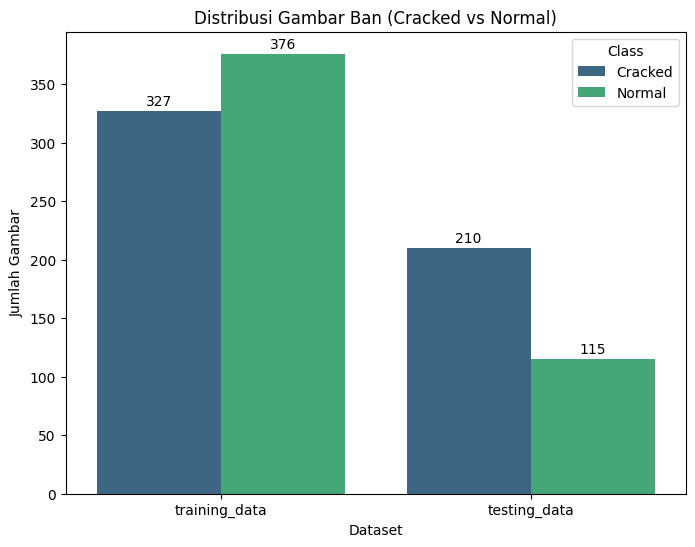

In [47]:
# Bar Plot
# Set path to dataset
path = "Tire Textures"

# Set subfolders
subfolders = ["training_data", "testing_data"]

# Create empty dataframe
data_textures = []

# Iterate over subfolders
for subfolder in subfolders:
    cracked_files = os.listdir(os.path.join(path, subfolder, "cracked"))
    cracked_count = len(cracked_files)
    
    normal_files = os.listdir(os.path.join(path, subfolder, "normal"))
    normal_count = len(normal_files)
    
    data_textures.append({"Dataset": subfolder, "Class": "Cracked", "Count": cracked_count})
    data_textures.append({"Dataset": subfolder, "Class": "Normal", "Count": normal_count})

# Convert to DataFrame
df_textures = pd.DataFrame(data_textures)

# Plot with seaborn
plt.figure(figsize=(8,6))
ax = sns.barplot(data=df_textures, x="Dataset", y="Count", hue="Class", palette="viridis")

# Tambahkan angka di atas bar
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=10, padding=2)

plt.title("Distribusi Gambar Ban (Cracked vs Normal)")
plt.ylabel("Jumlah Gambar")
plt.xlabel("Dataset")
plt.show()


Insight Distribusi Dataset  :

1. Training Data
    - Jumlah gambar Normal lebih banyak (376) dibanding Cracked (327).
    - Selisihnya tidak terlalu besar → dataset training relatif seimbang.
    - Kondisi ini bagus karena model CNN bisa belajar dengan representasi yang cukup adil dari kedua kelas.
2. Testing Data
    - Jumlah gambar Cracked lebih dominan (210) dibanding Normal (115).
    - Distribusi testing data tidak seimbang → bisa membuat evaluasi model cenderung bias ke kelas Cracked.
3. Perbedaan Distribusi Training vs Testing
    - Training data: relatif seimbang (hanya selisih 49 gambar).
    - Testing data: cukup timpang, jumlah Cracked hampir 2x lebih banyak daripada Normal.
    - Hal ini berarti meskipun model dilatih secara adil, saat diuji bisa terlihat performa lebih bagus di kelas mayoritas (Cracked).

---

## **B.2 - PieChart**

C:\Users\Rivaldi Revin\AppData\Local\Temp\ipykernel_20408\3909345083.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub["Count"] = df_sub["Count"].astype(int)  # pastikan numeric


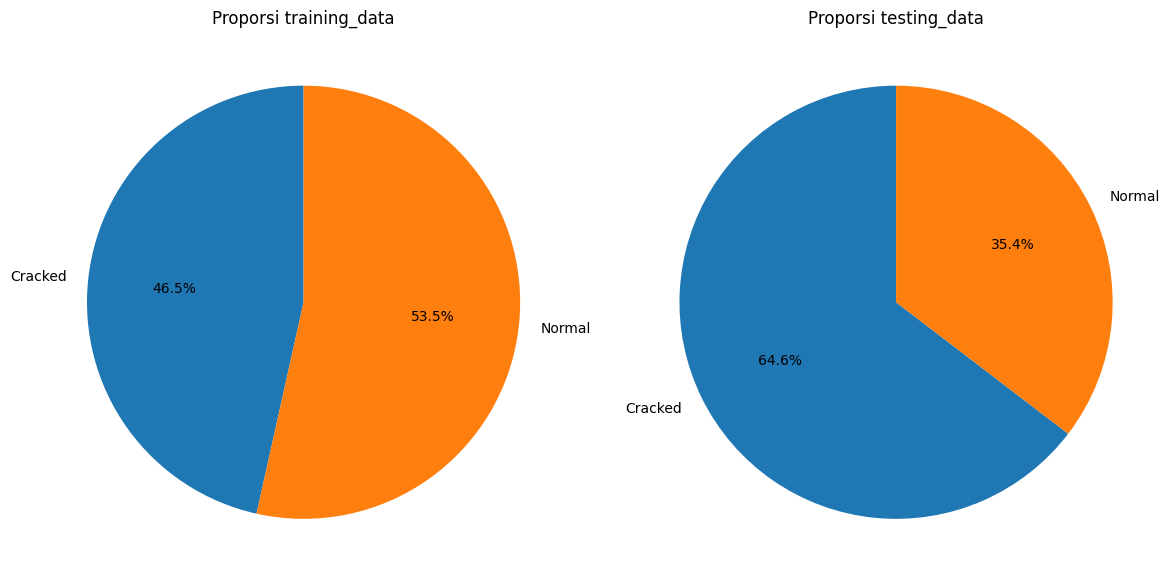

In [ ]:
# Pie Chart
# Buat 2 pie chart dalam 1 figure
fig, axes = plt.subplots(1, 2, figsize=(12,6))

# Loop untuk training & testing
for i, subset in enumerate(subfolders):
    df_sub = df_textures[df_textures["Dataset"] == subset]
    df_sub["Count"] = df_sub["Count"].astype(int) 
    
    axes[i].pie(df_sub["Count"], labels=df_sub["Class"], autopct='%1.1f%%', startangle=90)
    axes[i].set_title(f"Proporsi {subset}")

plt.tight_layout()
plt.show()

Insight Proporsi Dataset Ban (Normal vs Cracked) :

1. Data Training
    - Distribusi cukup seimbang: Normal 53.5% dan Cracked 46.5%.
    - Perbedaan persentase tidak terlalu besar, sehingga model CNN memiliki peluang belajar dari kedua kelas dengan representasi yang hampir sama.
    - Kondisi ini baik untuk menghindari bias model terhadap salah satu kelas.
2. Data Testing
    - Distribusi lebih timpang: Cracked 64.6% dan Normal 35.4%.
    - Dominasi data Cracked bisa menyebabkan evaluasi model lebih berat ke kelas tersebut. Jika model hanya mengandalkan distribusi, ada potensi accuracy score terlihat tinggi, tetapi sebenarnya model bias ke kelas mayoritas.
3. Perbedaan Proporsi Training vs Testing
    - Pada training, kelas relatif seimbang → model belajar lebih adil antara Normal dan Cracked.
    - Pada testing, kelas lebih condong ke Cracked → evaluasi bisa menampilkan ketidakseimbangan performa antar kelas. Oleh karena itu, selain akurasi, metrik evaluasi lain seperti precision, recall, dan F1-score per kelas perlu digunakan agar penilaian lebih objektif.
4. Implikasi untuk Model CNN
    - Perbedaan distribusi ini perlu diantisipasi, misalnya dengan:
    - Menyusun ulang dataset testing agar lebih seimbang.
    - Menggunakan teknik evaluasi tambahan seperti confusion matrix dan classification report.
    - Bila dataset asli memang tidak seimbang, bisa dipertimbangkan oversampling/undersampling atau class weighting saat training.

---

## **B.3 - Menampilkan gambar dari tiap kelas**

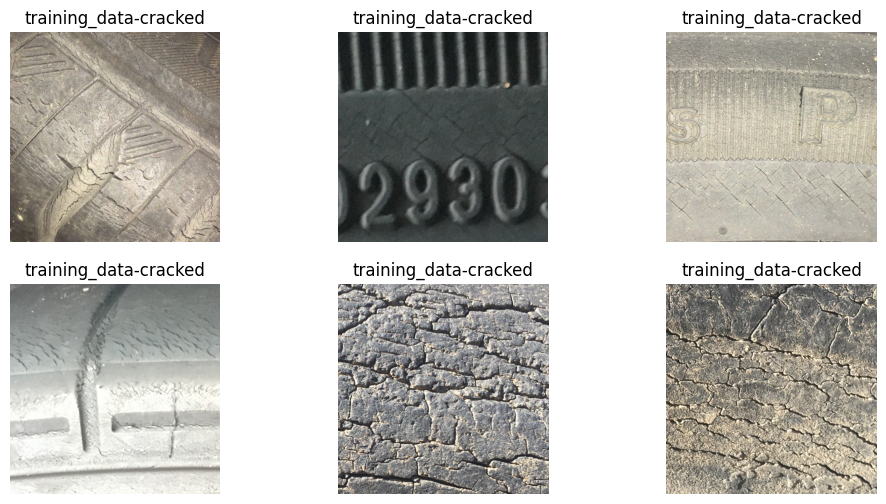

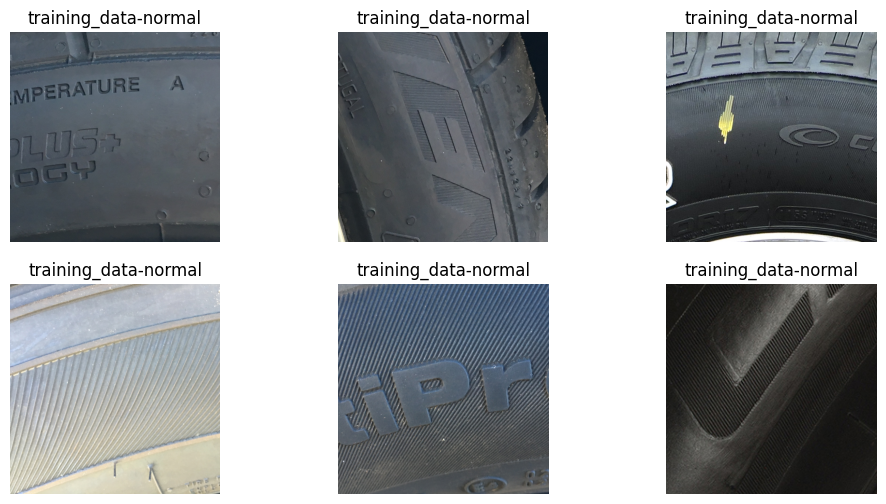

In [60]:
# Fungsi untuk menampilkan gambar random dari setiap kelas
def show_examples(base_path, subfolder, cls, n=6):
    files = os.listdir(os.path.join(base_path, subfolder, cls))
    samples = random.sample(files, min(n, len(files)))

    plt.figure(figsize=(12, 6))
    for i, file in enumerate(samples):
        img = Image.open(os.path.join(base_path, subfolder, cls, file))
        ax = plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"{subfolder}-{cls}")
    plt.show()

path = "Tire Textures"

show_examples(path, "training_data", "cracked")
show_examples(path, "training_data", "normal")


Insight Gambar Dataset Ban (Normal vs Cracked)  :

1. Ban Normal
    - Permukaan terlihat lebih halus dan seragam, dengan pola alur ban (tread) yang masih jelas.
    - Tidak ditemukan retakan mencolok; tekstur dominan berupa garis lurus atau huruf/angka emboss dari pabrikan.
    - Variasi pencahayaan ada, namun secara umum distribusi tekstur tetap konsisten.

2. Ban Cracked
    - Permukaan menunjukkan banyak retakan tidak beraturan dengan intensitas bervariasi.
    - Beberapa gambar menampilkan retakan kecil menyebar (fine cracks), sementara yang lain berupa retakan besar (deep cracks).
    - Tekstur lebih kasar, permukaan tampak tidak homogen, sehingga menghasilkan pola visual yang sangat berbeda dengan ban normal.

3. Perbedaan Visual Utama
    - Normal → tekstur rapi, permukaan relatif mulus, pola geometris (alur, tulisan, angka) masih dominan.
    - Cracked → tekstur rusak, permukaan pecah-pecah, distribusi retakan membuat kontras cahaya lebih kuat dan tidak beraturan.
    - Perbedaan ini cukup signifikan, sehingga dapat menjadi fitur visual penting untuk proses klasifikasi dengan CNN.

4. Implikasi untuk Training CNN
    - CNN dapat memanfaatkan tekstur retakan sebagai ciri pembeda utama antara kelas normal dan cracked.
    - Variasi dalam dataset (pencahayaan, sudut pengambilan gambar, ketebalan retakan) justru positif karena membuat model lebih robust terhadap kondisi nyata di lapangan.
    - Namun, untuk akurasi lebih tinggi, perlu augmentasi data (rotasi, flip, zoom) agar model tidak hanya mengenali pola retakan dari sudut tertentu saja.

---

## **B.4 - Analisa ukuran gambar**

             Width       Height
count   400.000000   400.000000
mean   1502.360000  1502.960000
std     857.751201   857.762864
min     224.000000   224.000000
25%     615.500000   615.500000
50%    1696.000000  1696.000000
75%    2262.750000  2262.750000
max    2994.000000  2994.000000


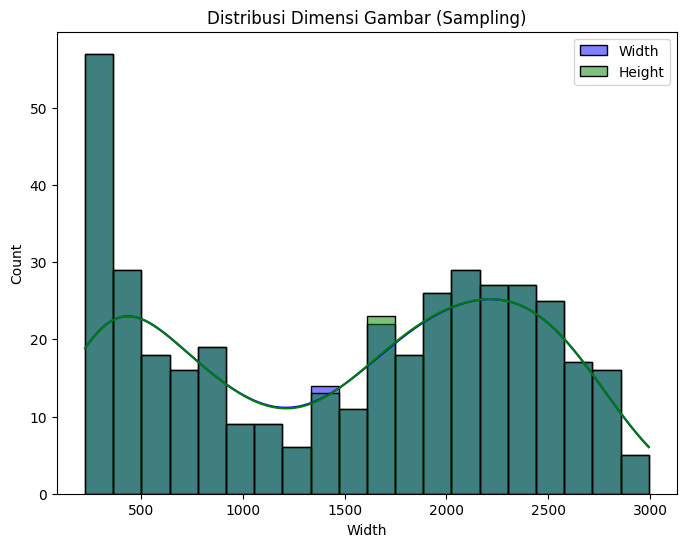

In [50]:
# Analisa ukuran gambar, output yang dihasilkan berupa pixel (per 100 gambar)
image_shapes = []
for subfolder in ["training_data", "testing_data"]:
    for cls in ["cracked", "normal"]:
        class_path = os.path.join(path, subfolder, cls)
        files = os.listdir(class_path)
        for f in files[:100]:  # ambil sampling 100 gambar saja
            img = Image.open(os.path.join(class_path, f))
            image_shapes.append(img.size)  # (width, height)

df_shapes = pd.DataFrame(image_shapes, columns=["Width", "Height"])
print(df_shapes.describe())

plt.figure(figsize=(8,6))
sns.histplot(df_shapes["Width"], bins=20, kde=True, color="blue", label="Width")
sns.histplot(df_shapes["Height"], bins=20, kde=True, color="green", label="Height")
plt.legend()
plt.title("Distribusi Dimensi Gambar (Sampling)")
plt.show()


Insight Distribusi Dimensi Gambar :

1. Variasi Lebar (Width) dan Tinggi (Height)
    - Gambar memiliki dimensi yang cukup beragam, mulai dari < 500 piksel hingga hampir 3000 piksel.
    - Distribusi tidak seragam; ada kelompok kecil gambar dengan resolusi rendah, dan kelompok lain dengan resolusi tinggi.

2. Kelompok Utama (Cluster) Resolusi
    - Resolusi rendah: banyak gambar berada pada lebar sekitar 300–500 piksel, kemungkinan hasil kompresi atau pengambilan dari sumber yang berbeda.
    - Resolusi menengah: sebagian gambar berada pada rentang 1000–1500 piksel.
    - Resolusi tinggi: cukup banyak gambar dengan dimensi 2000–2500 piksel, menunjukkan adanya dataset dengan kualitas lebih tinggi.

3. Ketidakseimbangan Dimensi

    - Histogram menunjukkan beberapa puncak (multimodal), artinya dataset terdiri dari kombinasi gambar dengan ukuran sangat bervariasi.
    - Hal ini penting karena model CNN biasanya membutuhkan input dengan ukuran seragam → perlu dilakukan resize atau augmentasi agar konsistensi terjaga.

4. Implikasi untuk Model CNN
    - Resolusi yang terlalu rendah (misalnya < 500 piksel) berisiko kehilangan detail tekstur ban (retakan kecil mungkin tidak terlihat jelas).
    - Resolusi yang terlalu tinggi (2000+ piksel) bisa meningkatkan beban komputasi tanpa selalu meningkatkan akurasi, sehingga perlu strategi resize ke ukuran optimal (misalnya 224x224 atau 260x260).
    - Distribusi ini mengindikasikan perlunya standardisasi ukuran input agar model bisa belajar secara konsisten.

---

## **B.5 - Analisis intensitas warna (histogram grayscale)**

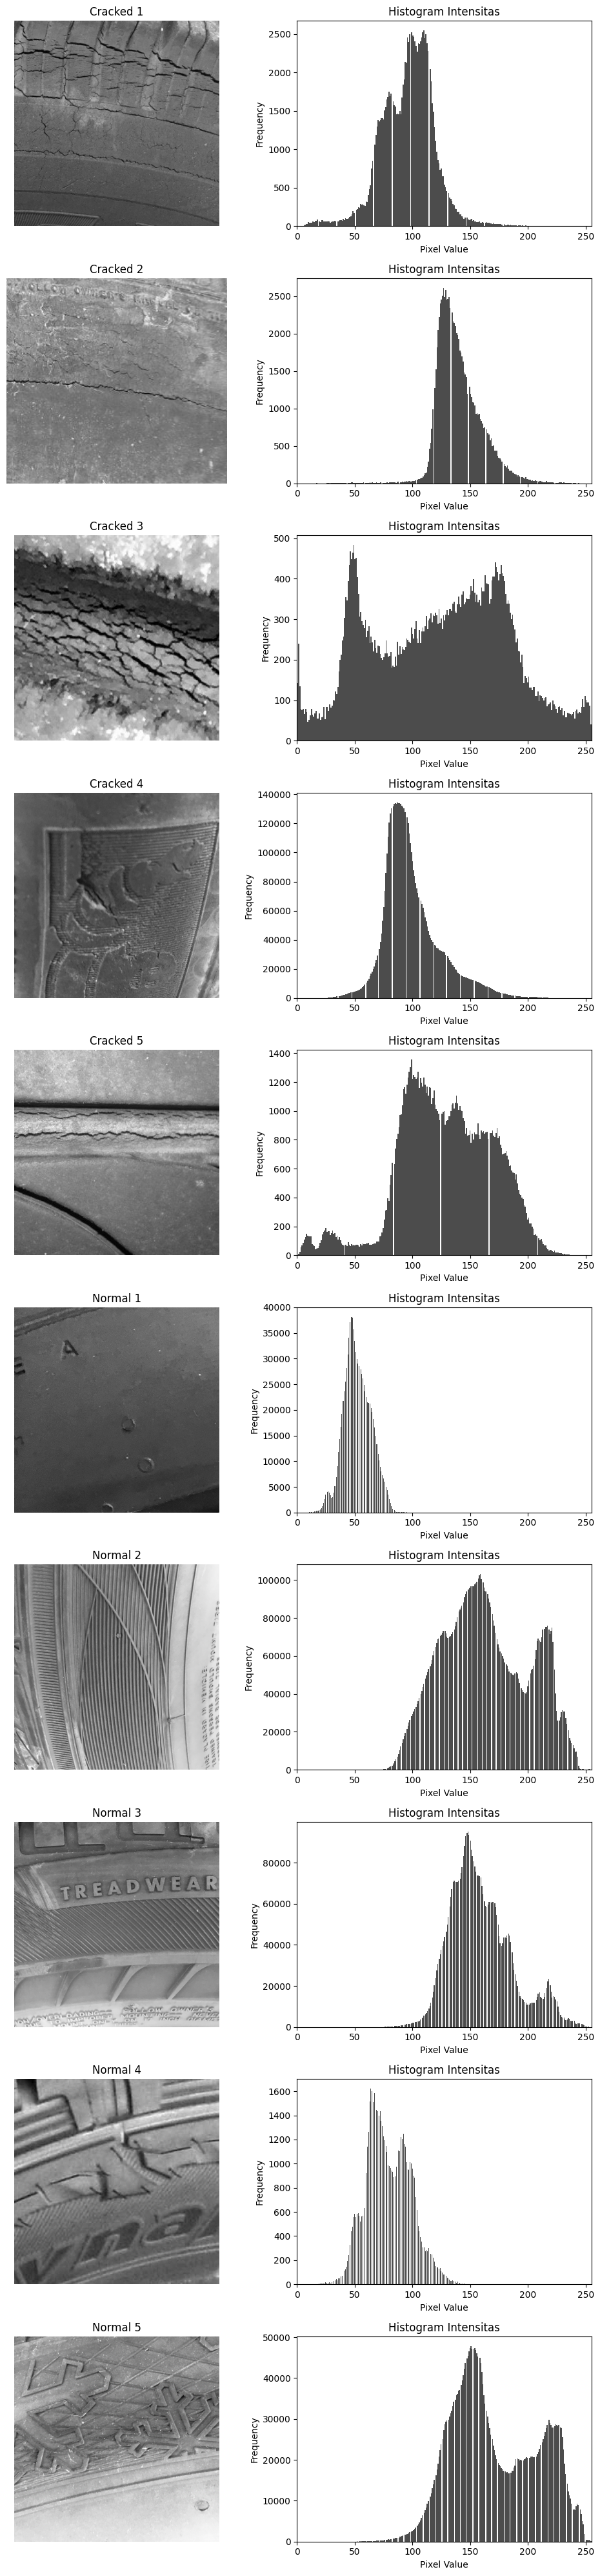

In [ ]:
# Fungsi untuk menampilkan gambar + histogram grayscale
def show_image_and_hist(image_path, ax_img, ax_hist, title=""):
    img = Image.open(image_path).convert("L")  # grayscale
    arr = np.array(img)

    # Tampilkan gambar
    ax_img.imshow(arr, cmap="gray")
    ax_img.axis("off")
    ax_img.set_title(title)

    # Tampilkan histogram grayscale
    ax_hist.hist(arr.ravel(), bins=256, color="black", alpha=0.7)
    ax_hist.set_xlim(0, 255)
    ax_hist.set_title("Histogram Intensitas")
    ax_hist.set_xlabel("Pixel Value")
    ax_hist.set_ylabel("Frequency")

# Path dataset
path = "Tire Textures"

# Ambil 5 sample cracked dan 5 normal
cracked_samples = random.sample(os.listdir(os.path.join(path, "training_data", "cracked")), 5)
normal_samples  = random.sample(os.listdir(os.path.join(path, "training_data", "normal")), 5)

samples = [(os.path.join(path, "training_data", "cracked", f), f"Cracked {i+1}") for i, f in enumerate(cracked_samples)]
samples += [(os.path.join(path, "training_data", "normal", f), f"Normal {i+1}") for i, f in enumerate(normal_samples)]

# Plot 10 gambar + histogram (10 baris, 2 kolom)
fig, axes = plt.subplots(10, 2, figsize=(10, 40))

for i, (img_path, title) in enumerate(samples):
    show_image_and_hist(img_path, axes[i,0], axes[i,1], title)

plt.tight_layout()
plt.show()

Cara Membaca Histogram Grayscale :

1. Sumbu X (Pixel Value 0–255)
    - 0 = hitam pekat
    - 255 = putih terang
    - Nilai di antaranya (1–254) = gradasi abu-abu

2. Sumbu Y (Frequency / Count)
    - Menunjukkan berapa banyak pixel di dalam gambar yang memiliki intensitas tertentu.
    - Semakin tinggi bar/kurva → semakin banyak pixel dengan intensitas itu.

Insight dari Histogram Intensitas Warna :

1. Ban Cracked (Retak)
    - Pola histogram cenderung lebih menyebar (distribusi lebar) dengan beberapa puncak (multi-peak).
    - Hal ini karena tekstur retakan menghasilkan banyak variasi tingkat keabuan (grayscale) → dari area sangat gelap (retakan) hingga area terang (permukaan ban yang terkena cahaya).
    - Contoh: Cracked 1, 3, 5 menunjukkan histogram bergelombang dengan distribusi tidak merata → mengindikasikan permukaan tidak homogen.

2. Ban Normal
    - Pola histogram cenderung lebih terfokus (narrower) pada rentang nilai tertentu.
    - Permukaan ban normal lebih rata sehingga menghasilkan distribusi intensitas yang lebih konsisten.
    - Contoh: Normal 1 memiliki histogram tajam di area pixel value rendah → menunjukkan warna dominan gelap yang seragam.

3. Perbedaan Utama Cracked vs Normal
    - Ban Cracked: histogram memiliki variasi tinggi, tidak simetris, dan cenderung bergelombang → mencerminkan adanya tekstur kompleks dan ketidakrataan.
    - Ban Normal: histogram lebih stabil dengan 1–2 puncak dominan, distribusi lebih seragam → mencerminkan tekstur permukaan yang lebih halus dan konsisten.

4. Implikasi untuk CNN / Model Klasifikasi
    - Variasi intensitas pada ban cracked bisa menjadi fitur penting untuk membedakan dengan ban normal.
    - Dengan preprocessing grayscale, CNN dapat lebih mudah mengekstraksi pola tekstur retakan karena kontras antar-pixel cukup signifikan.
    - Histogram ini memberi bukti bahwa ban cracked memiliki pola distribusi pixel yang berbeda secara statistik dari ban normal, sehingga dapat dijadikan dasar klasifikasi.

---

# **C. Kesimpulan**

Kesimpulan Keseluruhan :

1. Kualitas Data
    - Gambar ban yang tersedia sudah merepresentasikan dua kondisi utama: Normal dan Cracked, dengan karakteristik visual yang jelas berbeda.
    - Hal ini memberikan dasar yang baik untuk melatih model deteksi berbasis CNN atau transfer learning.
2. Distribusi Training Data
    - Jumlah gambar pada kelas Normal (376) dan Cracked (327) relatif seimbang.
    - Kondisi ini positif karena model akan belajar dengan representasi yang adil dari kedua kelas tanpa risiko berat sebelah pada fase training.
3. Distribusi Testing Data
    - Jumlah gambar Cracked (210) jauh lebih banyak dibanding Normal (115).
    - Distribusi yang tidak seimbang ini dapat memengaruhi evaluasi model, di mana akurasi bisa tampak tinggi tetapi sebenarnya model lebih sering menebak kelas mayoritas.
4. Implikasi untuk Pemodelan
    - Dengan training data yang seimbang, model berpotensi memiliki kemampuan generalisasi yang baik.
    - Namun, karena testing data timpang, evaluasi model tidak cukup menggunakan akurasi saja, tetapi juga harus melihat precision, recall, F1-score, dan confusion matrix.
    - Jika ingin evaluasi lebih representatif, dapat dipertimbangkan stratified sampling atau penyeimbangan ulang testing data.

Insight : 

Dataset sudah cukup baik untuk melatih model deteksi kondisi ban karena memiliki perbedaan visual yang jelas dan distribusi training yang seimbang. Namun, testing data yang tidak seimbang perlu diantisipasi dengan penggunaan metrik evaluasi yang lebih lengkap agar hasil performa model tidak bias terhadap kelas mayoritas.